# Usage: scenario analysis
This is a quick tour of CovsirPhy. Details scenario analysis will be explained.
"Scenario analysis" means that we calculate the number of cases in the future phases with some sets of ODE parameter values. With this analysis, we can estimate the impact of our activities against the outbreak on the number of cases.

### Preparation
Prepare the packages.

In [1]:
# !pip install covsirphy

In [2]:
import covsirphy as cs
cs.__version__

'2.16.2-eta'

### Dataset preparation
Download the datasets to "../input" directory and load them.  
Please refer to [Usage: datasets](https://lisphilar.github.io/covid19-sir/usage_dataset.html) for the details.

In [3]:
data_loader = cs.DataLoader("../input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu()
# Population in each country
population_data = data_loader.population()
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt()
# The number of tests
pcr_data = data_loader.pcr()
# The number of vaccinations
vaccine_data = data_loader.vaccine()

### Start scenario analysis
As an example, we will analysis the number of cases in Japan.

In [4]:
snl = cs.Scenario(jhu_data, population_data, country="Japan", province=None)
# From version 2.17.0, we will prefer to use
# snl = cs.Scenario(country="Japan", province=None)
# snl.register(jhu_data, population_data, extras=[oxcgrt_data, pcr_data, vaccine_data])

In [5]:
# If you want to stop displaying figures when using interactive shell,
# snl.interactive = False
# For temporally, plese use snl.records(show_figure=False) etc.
# If you want save figures,
# snl.interactive = False
# and please use snl.records(filename="records.jpg") etc.

### Check records
Let's see the records at first. `Scenario.records()` method return the records as a pandas dataframe and show a line plot. Some kind of complement will be done for analysis, if necessary.

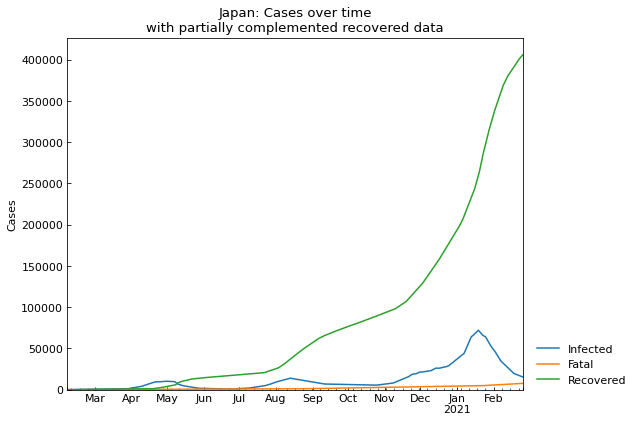

,Date,Infected,Fatal,Recovered
382,2021-02-22,17873,7474,400250
383,2021-02-23,17118,7529,401809
384,2021-02-24,16502,7584,403381
385,2021-02-25,15649,7647,405257
386,2021-02-26,15166,7722,406584


In [6]:
record_df = snl.records()
record_df.tail()
# From version 2.17.0 we can set variables:
# all available variables
# snl.records(variables="all")
# Select variables (we can select the varialbles of both og the main and extra datasets if registered)
# snl.records(vairables=["Tests", "Vaccinations"])

We can calculate the number of daily new cases with `Scenario.record_diff()` method.

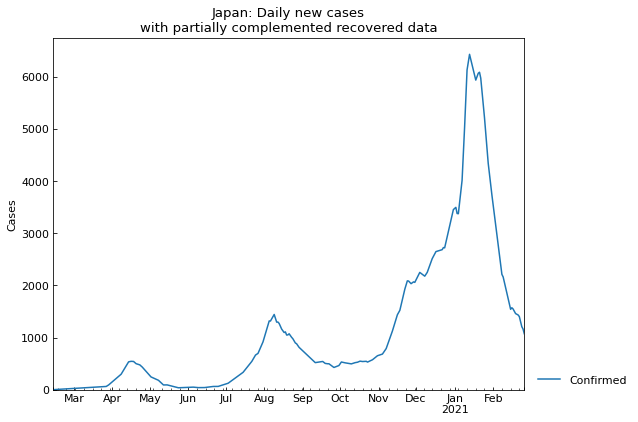

In [7]:
_ = snl.records_diff(variables=["Confirmed"], window=7)
# From version 2.17.0 we can set variables:
# all available variables
# snl.records_diff(variables="all")
# Select variables (we can select the varialbles of both og the main and extra datasets if registered)
# snl.records_diff(vairables=["Tests", "Vaccinations"])

`Scenario.show_complement()` method is useful to show the kinds of complement. The details of complement are explained in [Usage: datasets](https://lisphilar.github.io/covid19-sir/usage_dataset.html#The-number-of-cases-(JHU-style)) section.

In [8]:
complement_snl_df = snl.show_complement()
complement_snl_df.tail()

,Country,Province,Monotonic_confirmed,Monotonic_fatal,Monotonic_recovered,Full_recovered,Partial_recovered
0,Japan,-,False,False,True,False,True


### S-R trend analysis
S-R trend analysis finds the change points of SIR-derived ODE parameters. Details will be explained in [Usage (details: phases)](https://lisphilar.github.io/covid19-sir/usage_phases.html).

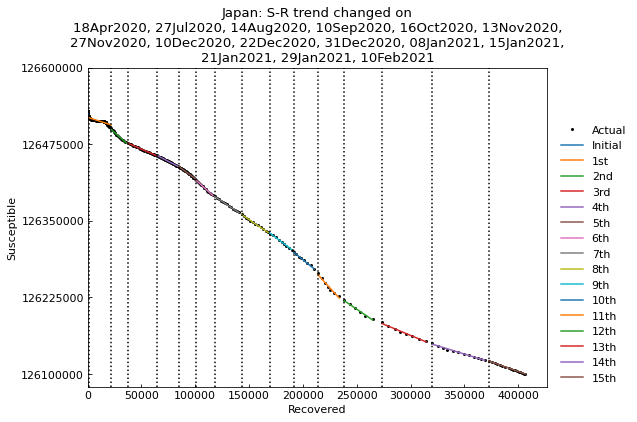

,Type,Start,End,Population
0th,Past,06Feb2020,17Apr2020,126529100
1st,Past,18Apr2020,26Jul2020,126529100
2nd,Past,27Jul2020,13Aug2020,126529100
3rd,Past,14Aug2020,09Sep2020,126529100
4th,Past,10Sep2020,15Oct2020,126529100
5th,Past,16Oct2020,12Nov2020,126529100
6th,Past,13Nov2020,26Nov2020,126529100
7th,Past,27Nov2020,09Dec2020,126529100
8th,Past,10Dec2020,21Dec2020,126529100
9th,Past,22Dec2020,30Dec2020,126529100


In [9]:
# Perform S-R trend analysis and set phases
snl.trend(set_phases=True)
snl.summary()

### Hyperparameter estimation of ODE models
Here, we will estimate the parameter values of SIR-derived models. As an example, we use SIR-F model. Details of models will be explained in [Usage (details: theoritical datasets)](https://lisphilar.github.io/covid19-sir/usage_theoretical.html).

In [10]:
# Estimate the parameter values of SIR-F model
# Default value of timeout is 180 sec
snl.estimate(cs.SIRF, timeout=60)


<SIR-F model: parameter estimation>
Running optimization with 8 CPUs...


	15th phase (10Feb2021 - 26Feb2021): finished  468 trials in 0 min 20 sec


	 7th phase (27Nov2020 - 09Dec2020): finished  446 trials in 0 min 40 sec

	 0th phase (06Feb2020 - 17Apr2020): finished  526 trials in 0 min 50 sec

	 1st phase (18Apr2020 - 26Jul2020): finished  613 trials in 1 min  0 sec

	 2nd phase (27Jul2020 - 13Aug2020): finished  637 trials in 1 min  0 sec

	 4th phase (10Sep2020 - 15Oct2020): finished  646 trials in 1 min  0 sec

	 5th phase (16Oct2020 - 12Nov2020): finished  649 trials in 1 min  0 sec

	 3rd phase (14Aug2020 - 09Sep2020): finished  622 trials in 1 min  0 sec

	 6th phase (13Nov2020 - 26Nov2020): finished  650 trials in 1 min  0 sec

	14th phase (29Jan2021 - 09Feb2021): finished  119 trials in 0 min 10 sec

	11th phase (08Jan2021 - 14Jan2021): finished  352 trials in 0 min 30 sec

	13th phase (21Jan2021 - 28Jan2021): finished  350 trials in 0 min 30 sec

	 8th phase (10Dec2020 - 21Dec2020): finished  697 trials in 1 min  0 sec

	12th phase (15Jan2021 - 20Jan2021): finished  513 trials in 0 min 40 sec

	 9th phase (22Dec2020 - 30Dec2020): finished  806 trials in 1 min  0 sec

	10th phase (31Dec2020 - 07Jan2021): finished  966 trials in 1 min  0 sec

Completed optimization. Total: 2 min 22 sec


In [11]:
# Show the sumamry of parameter estimation
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/beta [day],1/gamma [day],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,17Apr2020,126529100,SIR-F,4.51,0.000098,0.002530,0.104825,0.020709,1440,0.000,9,48,395,0.267468,526,0 min 50 sec
1st,Past,18Apr2020,26Jul2020,126529100,SIR-F,0.56,0.085651,0.000231,0.030967,0.050003,1440,0.086,32,19,4331,0.462595,613,1 min 0 sec
2nd,Past,27Jul2020,13Aug2020,126529100,SIR-F,1.74,0.000744,0.000158,0.121966,0.069940,1440,0.001,8,14,6342,0.044802,637,1 min 0 sec
3rd,Past,14Aug2020,09Sep2020,126529100,SIR-F,0.78,0.000486,0.000988,0.072341,0.092071,1440,0.000,13,10,1011,0.027913,622,1 min 0 sec
4th,Past,10Sep2020,15Oct2020,126529100,SIR-F,0.90,0.001419,0.001138,0.092740,0.101224,1440,0.001,10,9,878,0.028558,646,1 min 0 sec
5th,Past,16Oct2020,12Nov2020,126529100,SIR-F,1.18,0.000987,0.001050,0.101633,0.085294,1440,0.001,9,11,952,0.055002,649,1 min 0 sec
6th,Past,13Nov2020,26Nov2020,126529100,SIR-F,1.62,0.000323,0.000748,0.132199,0.080904,1440,0.000,7,12,1336,0.017272,650,1 min 0 sec
7th,Past,27Nov2020,09Dec2020,126529100,SIR-F,1.14,0.000718,0.001382,0.100582,0.086423,1440,0.001,9,11,723,0.019021,446,0 min 40 sec
8th,Past,10Dec2020,21Dec2020,126529100,SIR-F,1.18,0.000174,0.001417,0.106240,0.088278,1440,0.000,9,11,705,0.015600,697,1 min 0 sec
9th,Past,22Dec2020,30Dec2020,126529100,SIR-F,1.21,0.017509,0.000184,0.107659,0.086981,1440,0.018,9,11,5434,0.016832,806,1 min 0 sec


### Accuracy of estimation

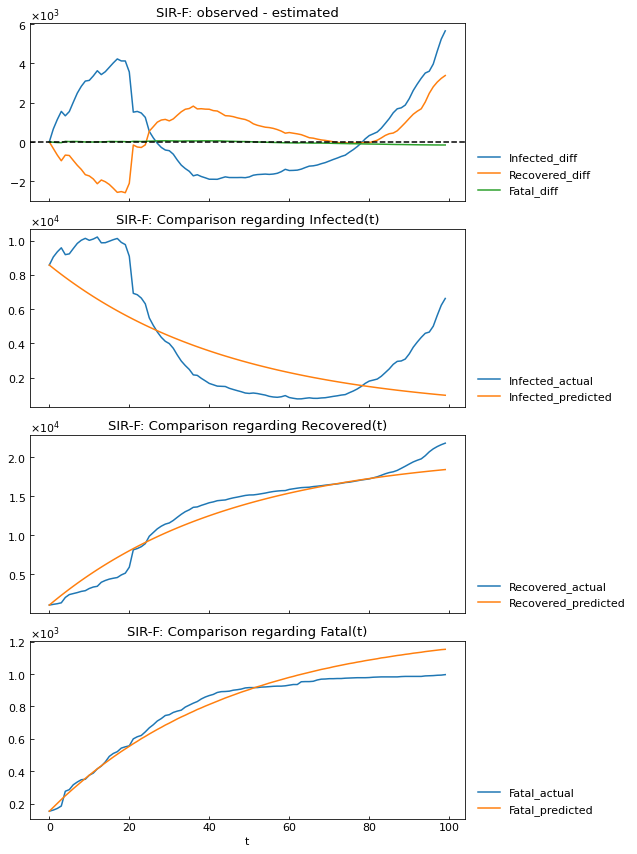

In [12]:
snl.estimate_accuracy(phase="1st")

### Get parameter value
We can get the parameter values of a phase using `Scenario.get()` method.

In [13]:
snl.get("Rt", phase="4th")

0.9

### Show parameter history
`Scenario.history()` method shows the trajectories of parameters (and the number of cases).

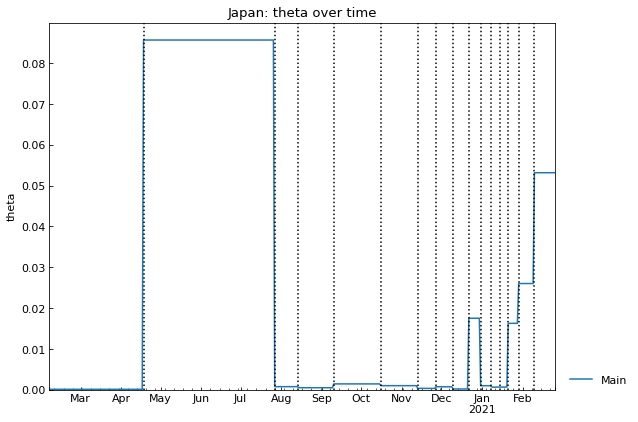

In [14]:
_ = snl.history(target="theta")

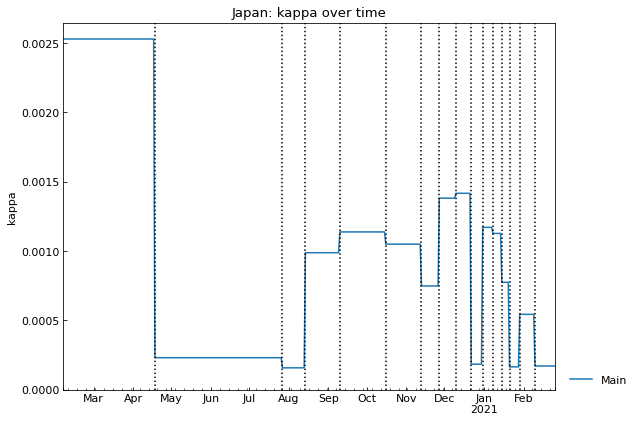

In [15]:
_ = snl.history(target="kappa")

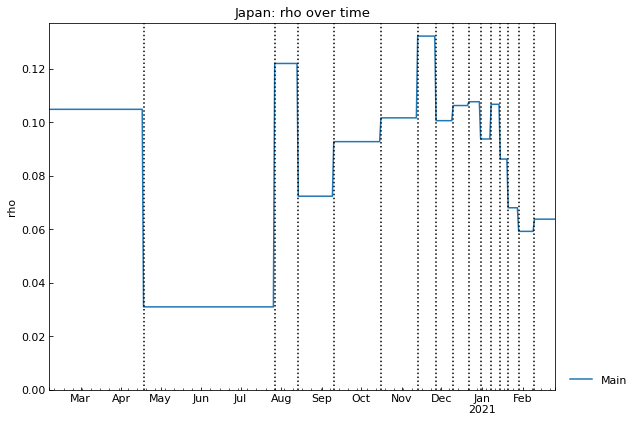

In [16]:
_ = snl.history(target="rho")

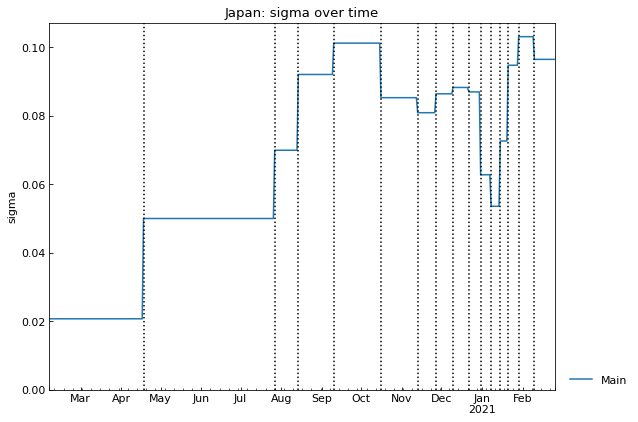

In [17]:
_ = snl.history(target="sigma")

Notes on the history of $\sigma$ value in japan (last updated: 28Dec2020):  
In Japan, we experienced two waves and we are in third wave. In the first wave (Apr - May), recovery period was too long because collapse of the medical care system occurred and no medicines were found.

Sigma values: the first wave < the second wave > the third wave

However, in the second wave (Jul - Oct), recovery period appears short because we have some effective medicines (not approved, in clinical study), yonger people (people un-associated to sever diseases) were infected.

In the third wave (Nov - ), older people tend to be infected and we are facing with medical collapse at this time...

### Show the history of reproduction number
$R_0$ ("R naught") means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)). When this value is larger than 1, the infection disease is outbreaking.

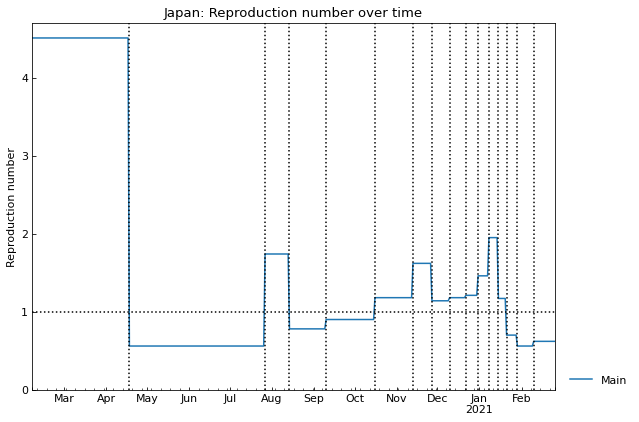

In [18]:
_ = snl.history(target="Rt")

### Simulate the number of cases
We can compare the actual and simulated (with estimated parameter values) number of confirmed/infected/recovered/fatal cases using `Scenario.history()` method.

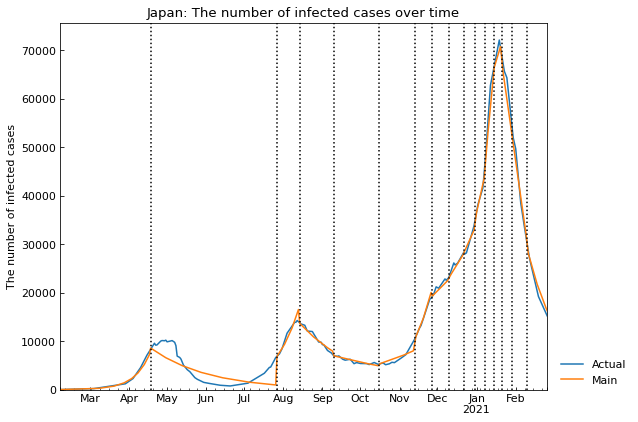

In [19]:
_ = snl.history("Infected")

### Main scenario
To investigate the effect of parameter changes, we will perform scenario analysis. In the main scenario, we will assume that the parameter values do not change after the last past phase.

i.e. If the parameter velues will not be changed until 01Apr2021, how many cases will be? We call this scenario as "Main" scenario.

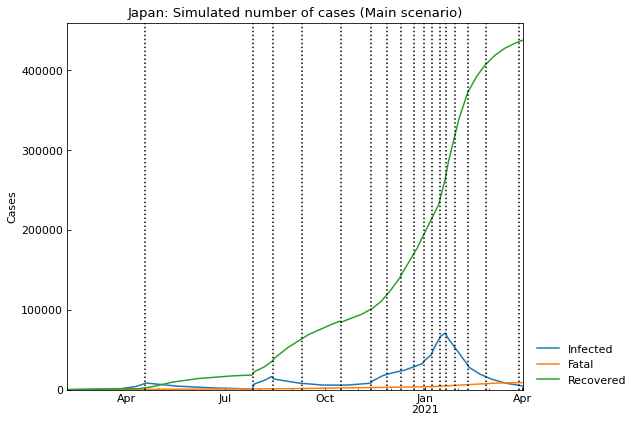

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,449731,8877,5236,435618
418,2021-03-30,450057,8895,5048,436114
419,2021-03-31,450372,8913,4867,436592
420,2021-04-01,450677,8930,4693,437054
421,2021-04-02,450969,8946,4525,437498


In [20]:
# Clear future phases in Main scenario
snl.clear(name="Main")
# Add one future phase 30 days with the parameter set of the last past phase
snl.add(days=30)
# Add one future phase until 01Apr2021 with the same parameter set
snl.add(end_date="01Apr2021", name="Main")
# Simulate the number of cases
snl.simulate(name="Main").tail()

### Medicine scenario
To investigate the effect of new medicines, we will assume that $\sigma$ will be changed in the future phases.

If $\sigma$ will be double in 30 days, how many cases will be? We will call this scenario as "Medicine" scenario.

In [21]:
# Calcuate the current sigma value of the last phase
sigma_current = snl.get("sigma", name="Main", phase="last")
sigma_current

0.09648562626860711

In [22]:
# Sigma value will be double
sigma_new = sigma_current * 2
sigma_new

0.19297125253721423

In [23]:
# Initialize "Medicine" scenario (with the same past phases as that of Main scenario)
snl.clear(name="Medicine")
# Add 30 days as a new future phases with the same parameter set
snl.add(name="Medicine", days=30, sigma=sigma_current)
# Add a phase until 01Apr2021 with doubled sigma value
snl.add(name="Medicine", end_date="01Apr2021", sigma=sigma_new)
snl.summary(name="Medicine")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/beta [day],1/gamma [day],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,17Apr2020,126529100,SIR-F,4.51,0.000098,0.002530,0.104825,0.020709,1440,0.000,9,48,395,0.267468,526,0 min 50 sec
1st,Past,18Apr2020,26Jul2020,126529100,SIR-F,0.56,0.085651,0.000231,0.030967,0.050003,1440,0.086,32,19,4331,0.462595,613,1 min 0 sec
2nd,Past,27Jul2020,13Aug2020,126529100,SIR-F,1.74,0.000744,0.000158,0.121966,0.069940,1440,0.001,8,14,6342,0.0448015,637,1 min 0 sec
3rd,Past,14Aug2020,09Sep2020,126529100,SIR-F,0.78,0.000486,0.000988,0.072341,0.092071,1440,0.000,13,10,1011,0.0279127,622,1 min 0 sec
4th,Past,10Sep2020,15Oct2020,126529100,SIR-F,0.90,0.001419,0.001138,0.092740,0.101224,1440,0.001,10,9,878,0.0285584,646,1 min 0 sec
5th,Past,16Oct2020,12Nov2020,126529100,SIR-F,1.18,0.000987,0.001050,0.101633,0.085294,1440,0.001,9,11,952,0.0550019,649,1 min 0 sec
6th,Past,13Nov2020,26Nov2020,126529100,SIR-F,1.62,0.000323,0.000748,0.132199,0.080904,1440,0.000,7,12,1336,0.0172719,650,1 min 0 sec
7th,Past,27Nov2020,09Dec2020,126529100,SIR-F,1.14,0.000718,0.001382,0.100582,0.086423,1440,0.001,9,11,723,0.0190212,446,0 min 40 sec
8th,Past,10Dec2020,21Dec2020,126529100,SIR-F,1.18,0.000174,0.001417,0.106240,0.088278,1440,0.000,9,11,705,0.0155997,697,1 min 0 sec
9th,Past,22Dec2020,30Dec2020,126529100,SIR-F,1.21,0.017509,0.000184,0.107659,0.086981,1440,0.018,9,11,5434,0.0168323,806,1 min 0 sec


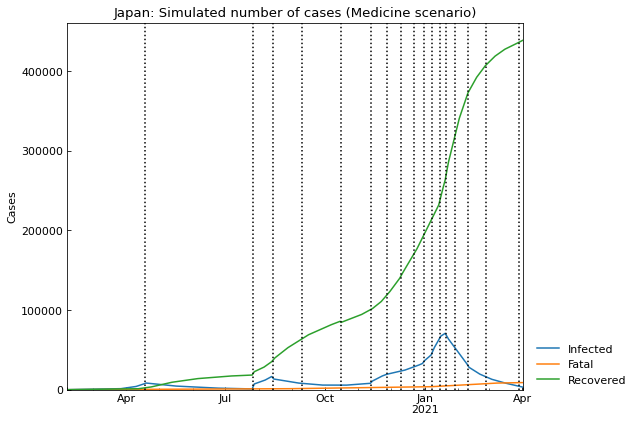

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,449731,8877,5236,435618
418,2021-03-30,450042,8894,4584,436564
419,2021-03-31,450315,8910,4013,437392
420,2021-04-01,450554,8923,3513,438118
421,2021-04-02,450763,8935,3076,438752


In [24]:
# Simulate the number of cases
snl.simulate(name="Medicine").tail()

### Short-term prediction of parameter values
With OxCGRT data, we can predict the parameter values of the future phases because [OxCGRT indicators](https://github.com/OxCGRT/covid-policy-tracker) (policy measures) impact on parameter values with delay period (calculated with `cenario.estimate_delay()` with version > 2.15.0-beta or set as recovery period).  

OxCGRT indicators are

- school_closing,
- workplace_closing,
- cancel_events, 
- gatherings_restrictions,
- transport_closing,
- stay_home_restrictions,
- internal_movement_restrictions,
- international_movement_restrictions,
- information_campaigns,
- testing_policy, and
- contact_tracing.

In [25]:
# Fitting with linear regression model (Elastic Net regression)
fit_dict = snl.fit(oxcgrt_data=oxcgrt_data, name="Forecast")
print(f"Determination coefficient: {fit_dict['score_train']} (train)")
print(f"Determination coefficient: {fit_dict['score_test']} (test)")
print("Intercept:")
fit_dict["intercept"].style.background_gradient(axis=None)
# From version 2.17.0, we will prefer to use
# snl = cs.Scenario(country="Japan", province=None)
# snl.register(jhu_data, population_data, extras=[oxcgrt_data, vaccine_data, pcr_data])
# snl.fit(name="Forecast")

Determination coefficient: 0.7026248349782418 (train)
Determination coefficient: 0.7125735585752363 (test)
Intercept:


,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
theta,-0.025642,0.049550,-0.022110,0.000000,0.027480,0.059809,0.049550,0.014465,0.000000,-0.070779,0.000000,-0.002296
kappa,0.000334,-0.000853,0.000572,0.000000,-0.000188,-0.001655,-0.000853,-0.000318,0.000000,0.000486,0.000000,0.000020
rho,0.020735,-0.041596,0.019162,0.000000,-0.026619,-0.051555,-0.041596,-0.012831,0.000000,0.059536,0.000000,0.001868
sigma,0.029070,-0.022208,-0.004011,0.000000,-0.030388,0.026175,-0.022208,-0.007976,0.000000,0.023805,0.000000,0.002420


In [26]:
# Short-term prediction
snl.predict(name="Forecast").summary(name="Forecast")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/beta [day],1/gamma [day],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,17Apr2020,126529100,SIR-F,4.51,0.000098,0.002530,0.104825,0.020709,1440,0.000,9,48,395,0.267468,526,0 min 50 sec
1st,Past,18Apr2020,26Jul2020,126529100,SIR-F,0.56,0.085651,0.000231,0.030967,0.050003,1440,0.086,32,19,4331,0.462595,613,1 min 0 sec
2nd,Past,27Jul2020,13Aug2020,126529100,SIR-F,1.74,0.000744,0.000158,0.121966,0.069940,1440,0.001,8,14,6342,0.0448015,637,1 min 0 sec
3rd,Past,14Aug2020,09Sep2020,126529100,SIR-F,0.78,0.000486,0.000988,0.072341,0.092071,1440,0.000,13,10,1011,0.0279127,622,1 min 0 sec
4th,Past,10Sep2020,15Oct2020,126529100,SIR-F,0.90,0.001419,0.001138,0.092740,0.101224,1440,0.001,10,9,878,0.0285584,646,1 min 0 sec
5th,Past,16Oct2020,12Nov2020,126529100,SIR-F,1.18,0.000987,0.001050,0.101633,0.085294,1440,0.001,9,11,952,0.0550019,649,1 min 0 sec
6th,Past,13Nov2020,26Nov2020,126529100,SIR-F,1.62,0.000323,0.000748,0.132199,0.080904,1440,0.000,7,12,1336,0.0172719,650,1 min 0 sec
7th,Past,27Nov2020,09Dec2020,126529100,SIR-F,1.14,0.000718,0.001382,0.100582,0.086423,1440,0.001,9,11,723,0.0190212,446,0 min 40 sec
8th,Past,10Dec2020,21Dec2020,126529100,SIR-F,1.18,0.000174,0.001417,0.106240,0.088278,1440,0.000,9,11,705,0.0155997,697,1 min 0 sec
9th,Past,22Dec2020,30Dec2020,126529100,SIR-F,1.21,0.017509,0.000184,0.107659,0.086981,1440,0.018,9,11,5434,0.0168323,806,1 min 0 sec


In [27]:
# Or, when you do not need 'fit_dict'
# snl.fit_predict(oxcgrt_data=oxcgrt_data, name="Forecast").summary(name="Forecast")
# From version 2.17.0, we will prefer to use
# snl.fit_predict(name="Forecast").summary(name="Forecast")

### Compare the scenarios
We will compare the scenarios with representative values, reproduction number and parameter values. Currently, we can compare the scenarios with the following indexes.

- max(Infected): max value of Infected
- argmax(Infected): the date when Infected shows max value
- Infected on …: Infected on the end date of the last phase
- Fatal on …: Fatal on the end date of the last phase

In [28]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 02Apr2021,Infected on 02Apr2021,Fatal on 02Apr2021,Confirmed on 09Mar2021,Infected on 09Mar2021,Fatal on 09Mar2021,16th_Rt,17th_Rt
Main,70729,20Jan2021,450969.0,4525.0,8946.0,NaN,NaN,NaN,0.62,0.62
Medicine,70729,20Jan2021,450763.0,3076.0,8935.0,NaN,NaN,NaN,0.62,0.31
Forecast,70729,20Jan2021,NaN,NaN,NaN,444285.0,15069.0,8177.0,0.96,-


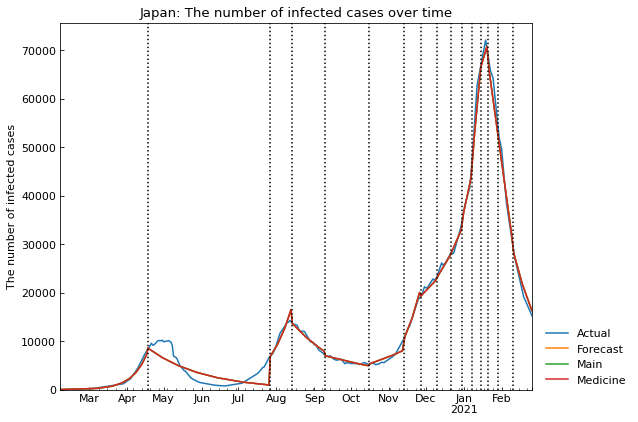

In [29]:
_ = snl.history(target="Infected")

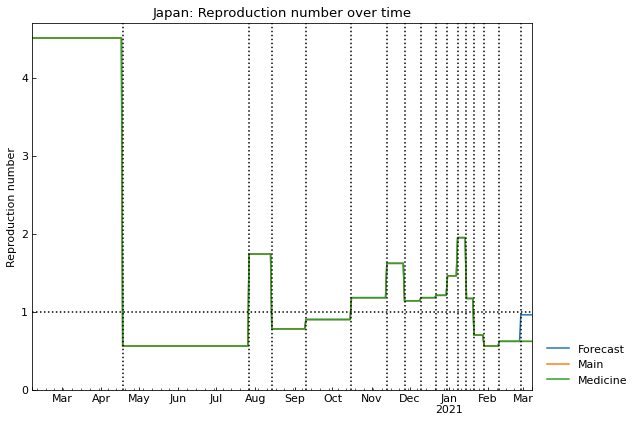

In [30]:
_ = snl.history(target="Rt")

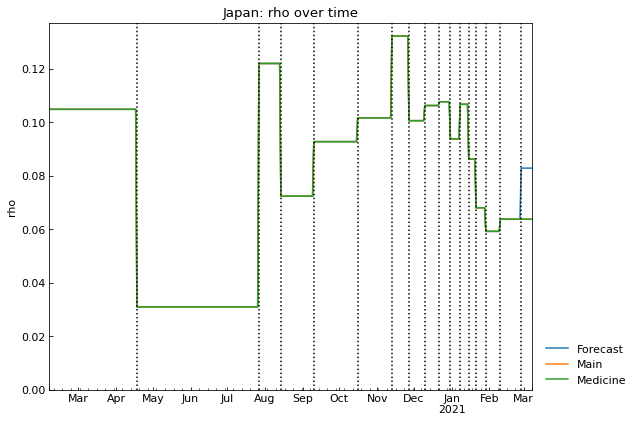

In [31]:
_ = snl.history(target="rho")

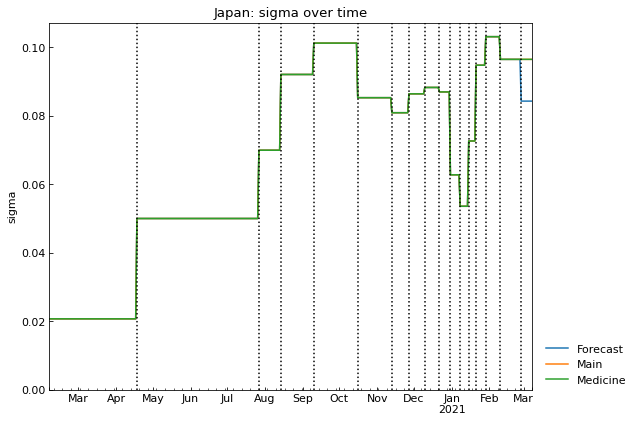

In [32]:
_ = snl.history(target="sigma")

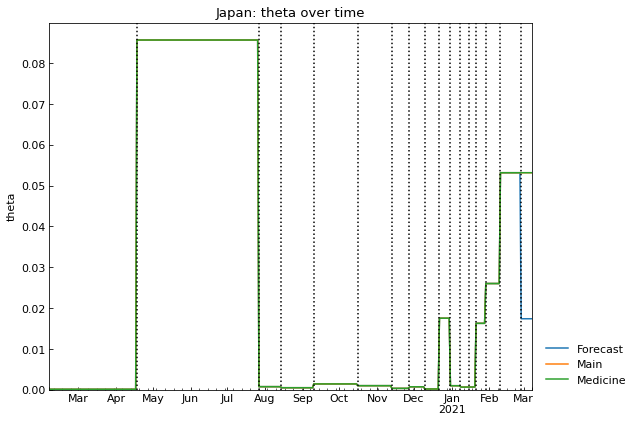

In [33]:
_ = snl.history(target="theta")

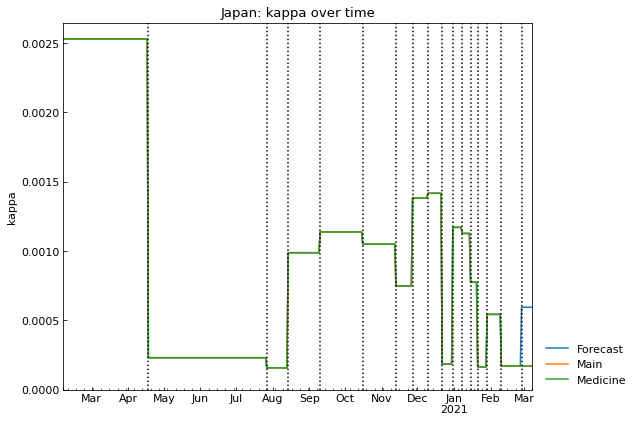

In [34]:
_ = snl.history(target="kappa")

### Change rate of parameters in main scenario
History of each parameter will be shown. Values will be divided by the values in 0th phase.

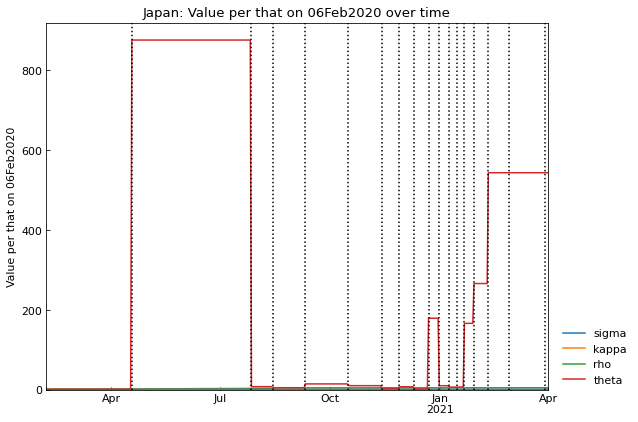

In [35]:
_ = snl.history_rate(name="Main")

## Retrospective analysis
We can evaluate the impact of measures using past records. How many people were infected if the parameter values have not changed sinse 01Sep2020?

In [36]:
# Perform retrospective analysis
snl_retro = cs.Scenario(jhu_data, population_data, "Japan")
snl_retro.retrospective("01Sep2020", model=cs.SIRF, control="Main", target="Retrospective")


<SIR-F model: parameter estimation>
Running optimization with 8 CPUs...


	16th phase (10Feb2021 - 26Feb2021): finished  722 trials in 0 min 30 sec


	 5th phase (10Sep2020 - 15Oct2020): finished  227 trials in 0 min 20 sec

	 4th phase (01Sep2020 - 09Sep2020): finished  352 trials in 0 min 30 sec

	 3rd phase (14Aug2020 - 31Aug2020): finished  786 trials in 1 min 20 sec

	 1st phase (18Apr2020 - 26Jul2020): finished  913 trials in 1 min 41 sec

	 9th phase (10Dec2020 - 21Dec2020): finished  712 trials in 1 min 10 sec

	 6th phase (16Oct2020 - 12Nov2020): finished 1039 trials in 1 min 50 sec

	11th phase (31Dec2020 - 07Jan2021): finished  222 trials in 0 min 20 sec

	13th phase (15Jan2021 - 20Jan2021): finished  215 trials in 0 min 20 sec

	 8th phase (27Nov2020 - 09Dec2020): finished 1001 trials in 1 min 51 sec

	 0th phase (06Feb2020 - 17Apr2020): finished 1206 trials in 2 min 21 sec

	 2nd phase (27Jul2020 - 13Aug2020): finished 1243 trials in 2 min 21 sec

	14th phase (21Jan2021 - 28Jan2021): finished  194 trials in 0 min 20 sec

	15th phase (29Jan2021 - 09Feb2021): finished  191 trials in 0 min 20 sec

	 7th phase (13Nov2020 - 26Nov2020): finished 1631 trials in 3 min  1 sec

	10th phase (22Dec2020 - 30Dec2020): finished 1378 trials in 2 min  1 sec

	12th phase (08Jan2021 - 14Jan2021): finished 2442 trials in 2 min 51 sec

Completed optimization. Total: 5 min  6 sec



<SIR-F model: parameter estimation>
Running optimization with 8 CPUs...


	 4th phase (01Sep2020 - 26Feb2021): finished 2149 trials in 0 min 40 sec

Completed optimization. Total: 0 min 41 sec


In [37]:
# Show the summary of estimation
cols = ["Start", "End", "ODE", "Rt", *cs.SIRF.PARAMETERS] + ["RMSLE", "Trials", "Runtime"]
snl_retro.summary(columns=cols)

Start        End    ODE    Rt     theta     kappa  \
Scenario      Phase                                                          
Main          0th    06Feb2020  17Apr2020  SIR-F  4.88  0.019678  0.000234   
              1st    18Apr2020  26Jul2020  SIR-F  0.56  0.067980  0.000249   
              2nd    27Jul2020  13Aug2020  SIR-F  1.62  0.000281  0.000137   
              3rd    14Aug2020  31Aug2020  SIR-F  0.82  0.000121  0.000294   
              4th    01Sep2020  09Sep2020  SIR-F  0.68  0.024458  0.000048   
              5th    10Sep2020  15Oct2020  SIR-F  0.90  0.003560  0.000301   
              6th    16Oct2020  12Nov2020  SIR-F  1.16  0.000222  0.000425   
              7th    13Nov2020  26Nov2020  SIR-F  1.65  0.001575  0.000224   
              8th    27Nov2020  09Dec2020  SIR-F  1.22  0.000930  0.000436   
              9th    10Dec2020  21Dec2020  SIR-F  1.20  0.000653  0.000558   
              10th   22Dec2020  30Dec2020  SIR-F  1.22  0.000324  0.000579   
              11th   31Dec2020  07Jan2021  SIR-F  1.47  0.002605  0.000301   
              12th   08Jan2021  14Jan2021  SIR-F  2.11  0.001045  0.000346   
              13th   15Jan2021  20Jan2021  SIR-F  1.26  0.005659  0.000180   
              14th   21Jan2021  28Jan2021  SIR-F  0.79  0.002565  0.000463   
              15th   29Jan2021  09Feb2021  SIR-F  0.57  0.000363  0.000709   
              16th   10Feb2021  26Feb2021  SIR-F  0.62  0.016133  0.000761   
Retrospective 0th    06Feb2020  17Apr2020  SIR-F  4.88  0.019678  0.000234   
              1st    18Apr2020  26Jul2020  SIR-F  0.56  0.067980  0.000249   
              2nd    27Jul2020  13Aug2020  SIR-F  1.62  0.000281  0.000137   
              3rd    14Aug2020  31Aug2020  SIR-F  0.82  0.000121  0.000294   
              4th    01Sep2020  26Feb2021  SIR-F  0.82  0.000121  0.000294   

                          rho     sigma     RMSLE  Trials       Runtime  
Scenario      Phase                                                      
Main          0th    0.034079  0.006611  0.271130    1206  2 min 21 sec  
              1st    0.009805  0.016179  0.462237     913  1 min 41 sec  
              2nd    0.042645  0.026197  0.044434    1243  2 min 21 sec  
              3rd    0.027240  0.033125  0.017625     786  1 min 20 sec  
              4th    0.022743  0.032536  0.012244     352  0 min 30 sec  
              5th    0.028892  0.031854  0.027222     227  0 min 20 sec  
              6th    0.037066  0.031413  0.055433    1039  1 min 50 sec  
              7th    0.043835  0.026315  0.017518    1631  3 min  1 sec  
              8th    0.035228  0.028501  0.016255    1001  1 min 51 sec  
              9th    0.036310  0.029665  0.013942     712  1 min 10 sec  
              10th   0.034762  0.027894  0.014391    1378  2 min  1 sec  
              11th   0.031433  0.021043  0.008341     222  0 min 20 sec  
              12th   0.038798  0.018050  0.020704    2442  2 min 51 sec  
              13th   0.029247  0.022958  0.010093     215  0 min 20 sec  
              14th   0.023639  0.029477  0.016604     194  0 min 20 sec  
              15th   0.021084  0.036114  0.016129     191  0 min 20 sec  
              16th   0.022151  0.034649  0.014418     722  0 min 30 sec  
Retrospective 0th    0.034079  0.006611  0.271130    1206  2 min 21 sec  
              1st    0.009805  0.016179  0.462237     913  1 min 41 sec  
              2nd    0.042645  0.026197  0.044434    1243  2 min 21 sec  
              3rd    0.027240  0.033125  0.017625     786  1 min 20 sec  
              4th    0.027240  0.033125  1.705926    2149  0 min 40 sec

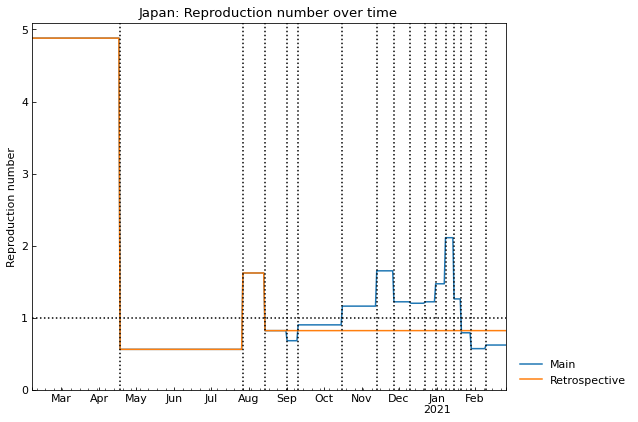

In [38]:
# History of reproduction number
_ = snl_retro.history("Rt")

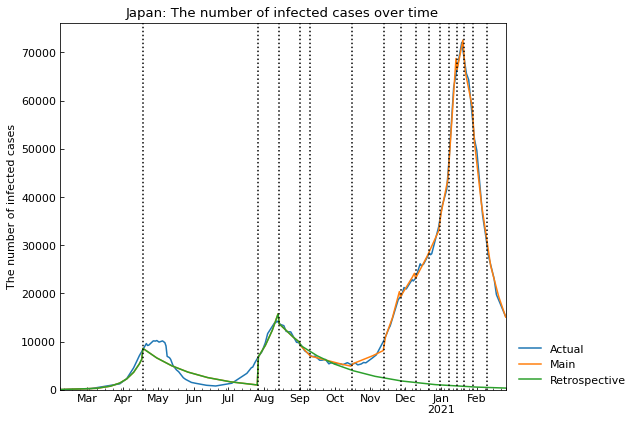

In [39]:
# History of Infected
_ = snl_retro.history("Infected")

In [40]:
# Show the representative values
snl_retro.describe()

,max(Infected),argmax(Infected),Confirmed on 27Feb2021,Infected on 27Feb2021,Fatal on 27Feb2021,4th_Rt,5th_Rt,6th_Rt,7th_Rt,8th_Rt,9th_Rt,10th_Rt,11th_Rt,12th_Rt,13th_Rt,14th_Rt,15th_Rt,16th_Rt
Main,72546,20Jan2021,431765,14475,7750,0.68,0.9,1.16,1.65,1.22,1.2,1.22,1.47,2.11,1.26,0.79,0.57,0.62
Retrospective,15734,13Aug2020,107636,333,1725,0.82,-,-,-,-,-,-,-,-,-,-,-,-
